In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic

#Clustering imports
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# To format floats
from IPython.display import display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df_aisles = pd.read_csv("../data/raw/aisles.csv")
df_departments = pd.read_csv("../data/raw/departments.csv")
df_orders = pd.read_csv("../data/interim/df_orders_clustered.csv") 
df_products = pd.read_csv("../data/raw/products.csv")
df_order_products__train = pd.read_csv("../data/raw/order_products__train.csv")
df_order_products__prior = pd.read_csv("../data/raw/order_products__prior.csv")

In [3]:
df_aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
df_aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [5]:
df_departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
df_departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


In [7]:
df_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,2539329,1,prior,1,2,8,nan,0
1,2398795,1,prior,2,3,7,15.00000,0
2,473747,1,prior,3,3,12,21.00000,0
3,2254736,1,prior,4,4,7,29.00000,0
4,431534,1,prior,5,4,15,28.00000,0


In [8]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3421083 entries, 0 to 3421082
Data columns (total 8 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
cluster                   int64
dtypes: float64(1), int64(6), object(1)
memory usage: 234.9+ MB


In [9]:
df_orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
count,3421083.00000,3421083.00000,3421083.00000,3421083.00000,3421083.00000,3214874.00000,3421083.00000
mean,1710542.00000,102978.20806,17.15486,2.77622,13.45202,11.11484,0.81361
std,987581.73982,59533.71779,17.73316,2.04683,4.22609,9.20674,0.91033
min,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000
25%,855271.50000,51394.00000,5.00000,1.00000,10.00000,4.00000,0.00000
50%,1710542.00000,102689.00000,11.00000,3.00000,13.00000,7.00000,0.00000
75%,2565812.50000,154385.00000,23.00000,5.00000,16.00000,15.00000,2.00000
max,3421083.00000,206209.00000,100.00000,6.00000,23.00000,30.00000,2.00000


In [10]:
orders_split = df_orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
orders_split['Ratio'] = orders_split["Total_orders"].apply(lambda x: x /orders_split['Total_orders'].sum())
orders_split

,eval_set,Total_orders,Ratio
0,prior,3214874,0.93972
1,test,75000,0.02192
2,train,131209,0.03835


We see how the prior records constitute around 94% of the orders, and also how there is almost twice as much orders in the train dataset as in the test dataset, although this last dataset is not available to the public.

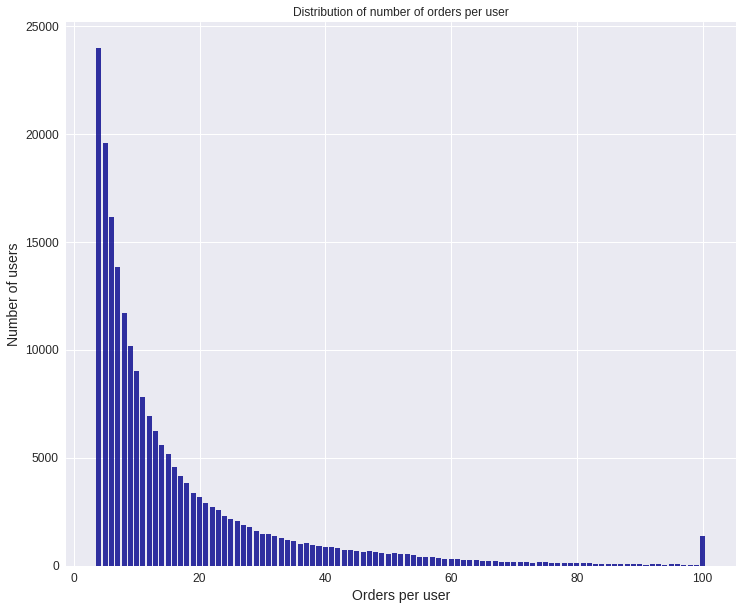

In [11]:
orders_per_user = df_orders.groupby("user_id")["order_number"].aggregate(max).reset_index()\
                  .order_number.value_counts()

plt.figure(figsize=(12,10))
plt.bar(orders_per_user.index, orders_per_user.values, alpha=0.8, color='darkblue')
plt.ylabel("Number of users")
plt.title('Distribution of number of orders per user')
plt.xlabel("Orders per user")
plt.show()

It seems to be capped at 100 orders per user. As expected, this is an exponential distribution, where lambda would be more than one based on the form of the figure.

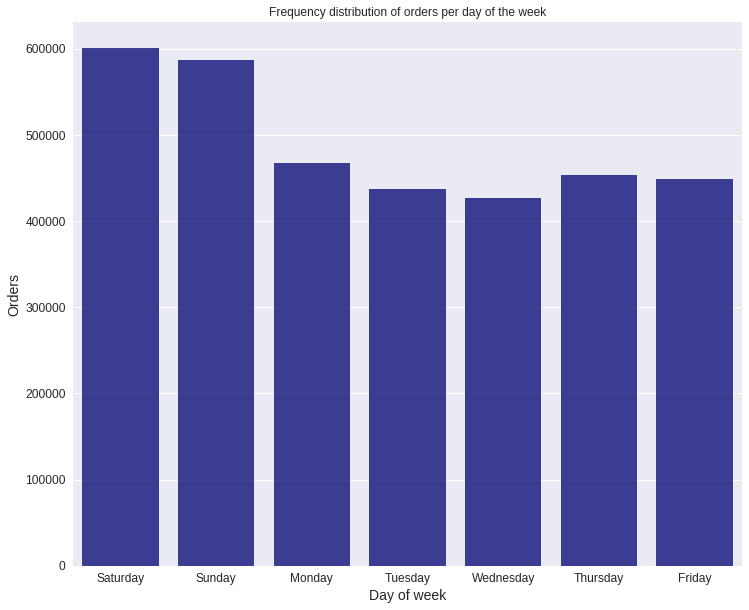

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
sns.countplot(x="order_dow", data=df_orders, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xlabel("Day of week")
plt.title("Frequency distribution of orders per day of the week")
labels = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
ax.set_xticklabels(labels)
plt.show()

Seems like Saturday and Sunday when the orders are high and low during weekdays, specially Wednesday.

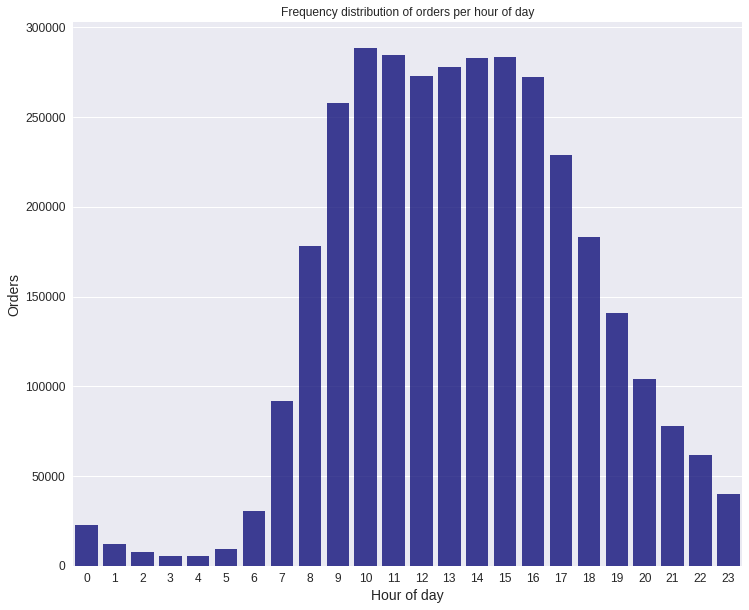

In [13]:
plt.figure(figsize=(12,10))
sns.countplot(x="order_hour_of_day", data=df_orders, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xlabel("Hour of day")
plt.title("Frequency distribution of orders per hour of day")
plt.show()

The majority of the orders are made during day time, between 9am and 17pm.

Both last graphs can be sumarized in the next heatmap.

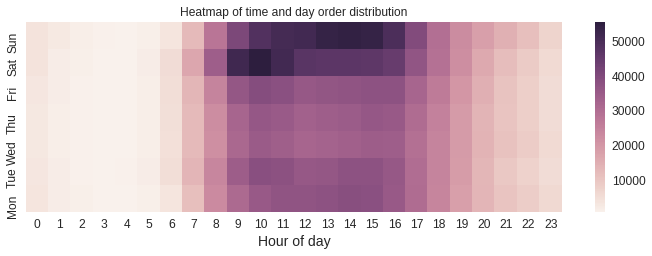

In [14]:
heatmap_df = df_orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
heatmap_df = heatmap_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

fig, ax = plt.subplots(figsize=(12,3.5))
sns.heatmap(heatmap_df)
plt.title("Heatmap of time and day order distribution")
plt.ylabel("")
plt.xlabel('Hour of day')
labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
ax.set_yticklabels(labels)
plt.show()

We can see how Saturday and Sunday morning are the most common times for shopping.

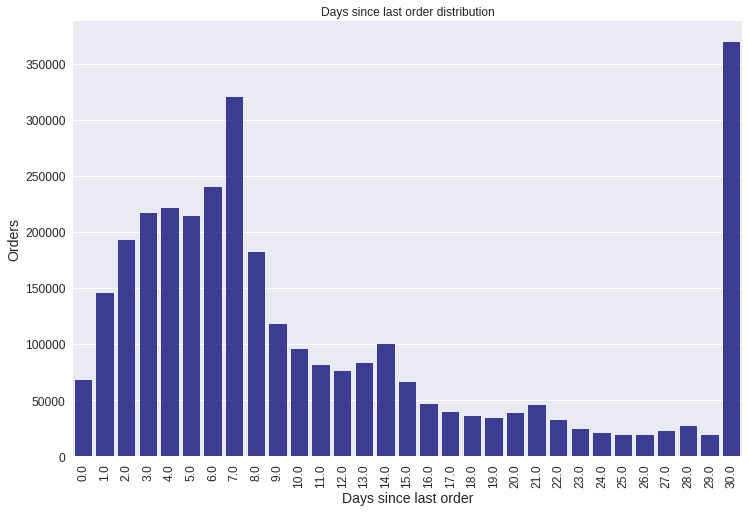

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(x="days_since_prior_order", data=df_orders, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xlabel('Days since last order')
plt.xticks(rotation="vertical")
plt.title("Days since last order distribution")
plt.show()

Again, we seem to have a capped variable here, where probably all orders where previous order was made more than a month ago appears in the dataset as 30 days ago. We can also see how the distribution is probably a Gamma distribution, and how the most common number of days between orders is exactly 1 week.

In [16]:
df_products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [17]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [18]:
df_products.describe()

,product_id,aisle_id,department_id
count,49688.00000,49688.00000,49688.00000
mean,24844.50000,67.76958,11.72869
std,14343.83442,38.31616,5.85041
min,1.00000,1.00000,1.00000
25%,12422.75000,35.00000,7.00000
50%,24844.50000,69.00000,13.00000
75%,37266.25000,100.00000,17.00000
max,49688.00000,134.00000,21.00000


In [19]:
df_order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [20]:
df_order_products__train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [21]:
df_order_products__train.describe()

,order_id,product_id,add_to_cart_order,reordered
count,1384617.00000,1384617.00000,1384617.00000,1384617.00000
mean,1706297.62109,25556.23573,8.75804,0.59859
std,989732.64887,14121.27245,7.42394,0.49018
min,1.00000,1.00000,1.00000,0.00000
25%,843370.00000,13380.00000,3.00000,0.00000
50%,1701880.00000,25298.00000,7.00000,1.00000
75%,2568023.00000,37940.00000,12.00000,1.00000
max,3421070.00000,49688.00000,80.00000,1.00000


In [22]:
df_order_products__prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
df_order_products__prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [24]:
df_order_products__prior.describe()

,order_id,product_id,add_to_cart_order,reordered
count,32434489.00000,32434489.00000,32434489.00000,32434489.00000
mean,1710748.51894,25576.33754,8.35108,0.58970
std,987300.69645,14096.68909,7.12667,0.49189
min,2.00000,1.00000,1.00000,0.00000
25%,855943.00000,13530.00000,3.00000,0.00000
50%,1711048.00000,25256.00000,6.00000,1.00000
75%,2565514.00000,37935.00000,11.00000,1.00000
max,3421083.00000,49688.00000,145.00000,1.00000


There is no missing data in datasets.

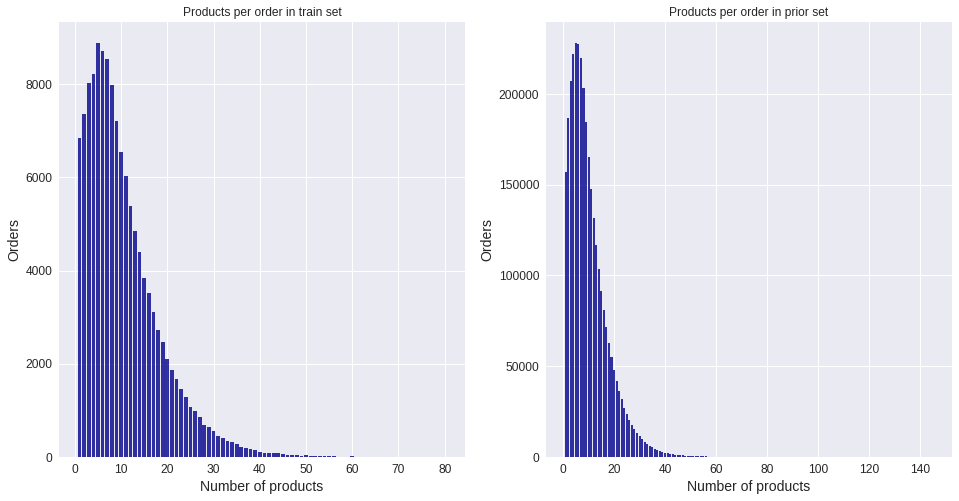

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)

# Train set
order_product_count = df_order_products__train.groupby("order_id")["add_to_cart_order"]\
                      .aggregate(max).reset_index().add_to_cart_order.value_counts()
plt.bar(order_product_count.index, order_product_count.values, alpha=0.8, color='darkblue')
plt.ylabel('Orders')
plt.title("Products per order in train set")
plt.xlabel('Number of products')

# Prior set
plt.subplot(1, 2, 2)
order_product_count = df_order_products__prior.groupby("order_id")["add_to_cart_order"]\
                      .aggregate(max).reset_index().add_to_cart_order.value_counts()
plt.bar(order_product_count.index, order_product_count.values, alpha=0.8, color='darkblue')
plt.ylabel('Orders')
plt.title("Products per order in prior set")
plt.xlabel('Number of products')

plt.show()

In [26]:
# Percentage of re-orders

def reorders(df, name):
    reorder = df.reordered.sum() / df.shape[0]
    print ("Percentage of reorders in {} set: {}".format(name,reorder))
    
reorders(df_order_products__prior, 'prior')
reorders(df_order_products__train, 'train')

Percentage of reorders in prior set: 0.5896974667922161
Percentage of reorders in train set: 0.5985944127509629


On an average, about 59% of the products in an order are re-ordered products.

Let's merge now prior orders information with product, aisle and department information to get some more insight of what kind of products people buy.

In [27]:
df_past_orders_info = pd.merge(pd.merge(pd.merge(df_order_products__prior, df_products, on="product_id",\
        how="left"), df_aisles, on="aisle_id", how="left"), df_departments, on="department_id", how="left")

In [28]:
df_past_orders_info.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


Most common products bought:

In [29]:
df_past_orders_info['product_name'].value_counts()[0:10]

Banana                    472565
Bag of Organic Bananas    379450
Organic Strawberries      264683
Organic Baby Spinach      241921
Organic Hass Avocado      213584
Organic Avocado           176815
Large Lemon               152657
Strawberries              142951
Limes                     140627
Organic Whole Milk        137905
Name: product_name, dtype: int64

A lot of organic products!

Top 10 Aisles

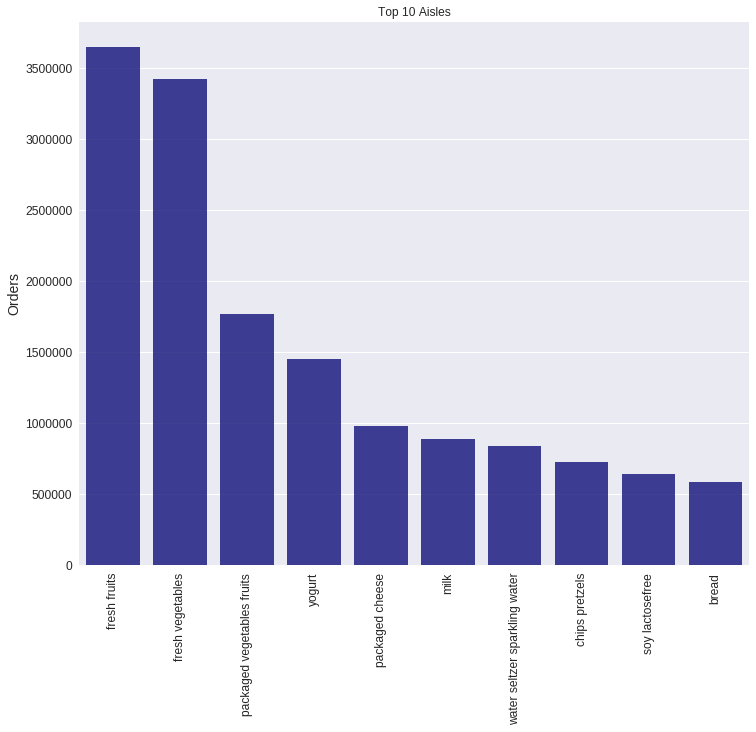

In [30]:
top_10_aisles = df_past_orders_info["aisle"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_aisles.index, top_10_aisles.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Aisles')
plt.show()

Top 10 Departments

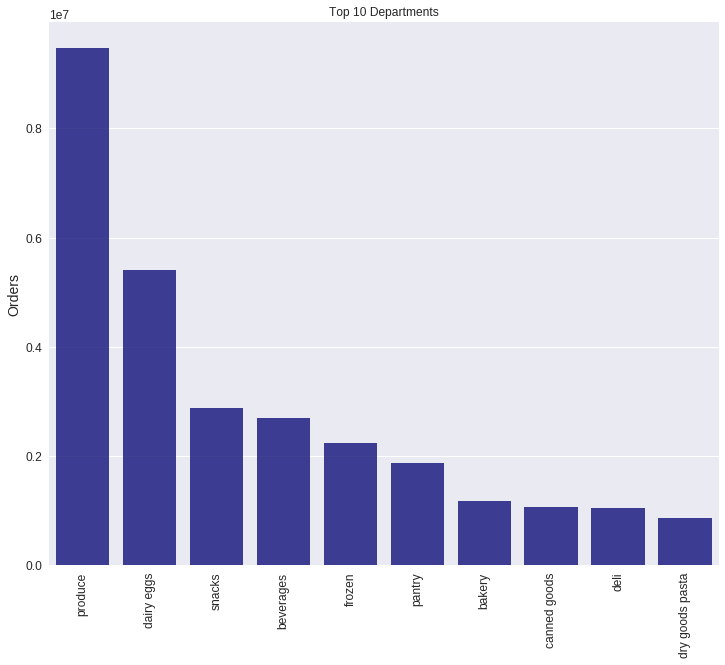

In [31]:
top_10_departments = df_past_orders_info["department"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_departments.index, top_10_departments.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Departments')
plt.show()

Let's see how all of them compare to each other

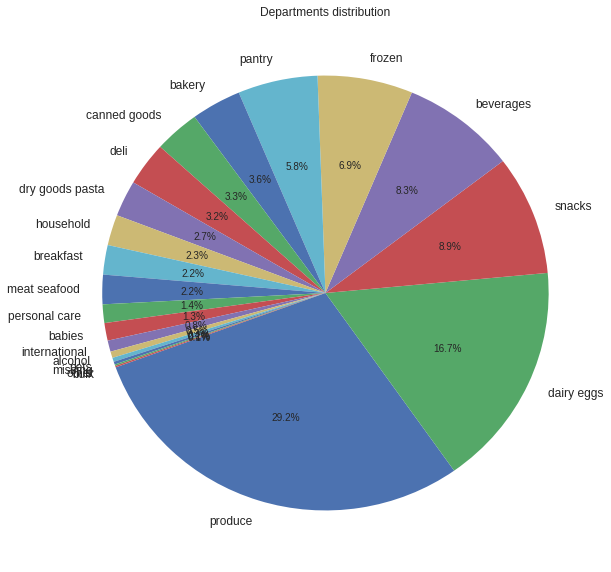

In [32]:
plt.figure(figsize=(10,10))
dept_distn = df_past_orders_info['department'].value_counts()
labels = (np.array(dept_distn.index))
sizes = (np.array((dept_distn / dept_distn.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution")
plt.show()

Top 10 products

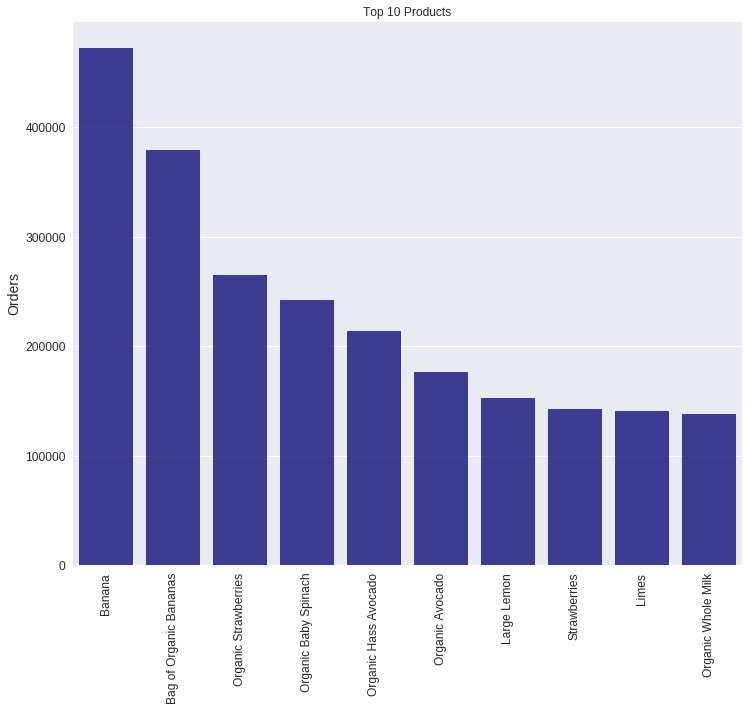

In [33]:
top_10_products = df_past_orders_info["product_name"].value_counts().head(10)

plt.figure(figsize=(12,10))
sns.barplot(top_10_products.index, top_10_products.values, alpha=0.8, color='darkblue')
plt.ylabel("Orders")
plt.xticks(rotation="vertical")
plt.title('Top 10 Products')
plt.show()

Bananas in number 1 and number 2. Also, organic products in 6 of the 10 most purchased products.

Let's see the distribution of products per department now.

In [34]:
products_department  = pd.merge(left=pd.merge(left=df_products, right=df_departments, how='left'), \
                                right=df_aisles, how='left')
products_department.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [35]:
products_grouped = products_department.groupby("department")["product_id"]\
          .aggregate({'Total_products': 'count'}).reset_index()
    
products_grouped['Ratio'] = products_grouped["Total_products"].apply(lambda x: \
                                                                     x /products_grouped['Total_products'].sum())
products_grouped.sort_values(by='Total_products', ascending=False, inplace=True)
products_grouped.head()

,department,Total_products,Ratio
17,personal care,6563,0.13208
20,snacks,6264,0.12607
16,pantry,5371,0.10809
3,beverages,4365,0.08785
10,frozen,4007,0.08064


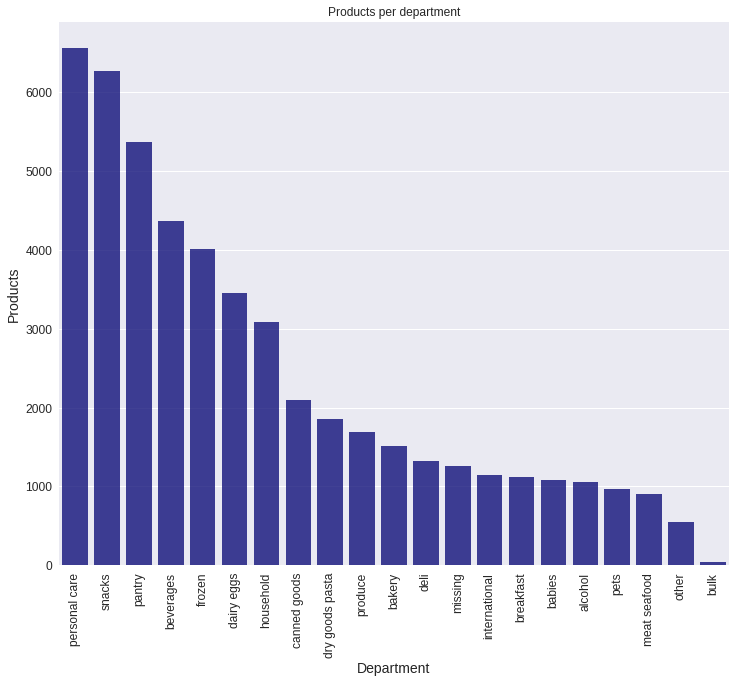

In [36]:
plt.figure(figsize=(12,10))
sns.barplot(products_grouped.department, products_grouped.Total_products, alpha=0.8, color='darkblue')
plt.ylabel('Products')
plt.xlabel('Department')
plt.xticks(rotation='vertical')
plt.title("Products per department")
plt.show()

#### Reorder ratios

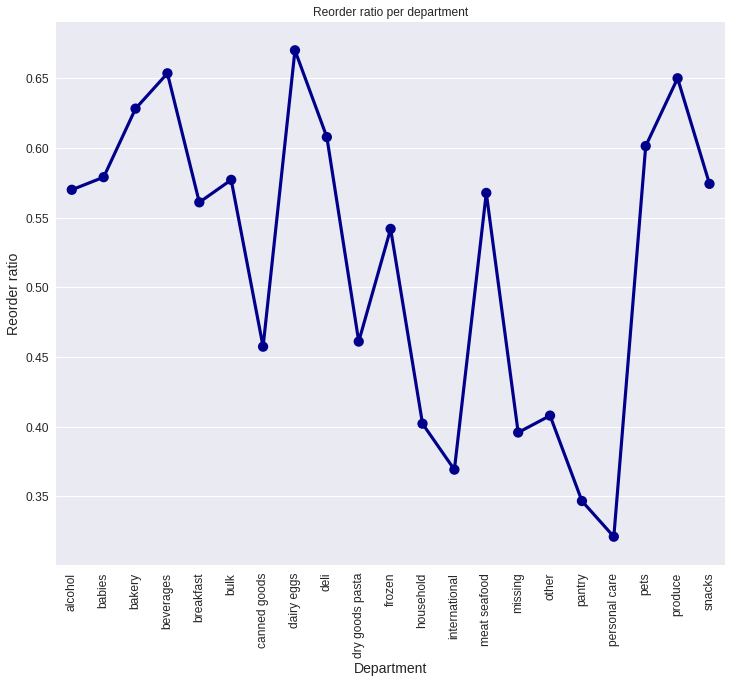

In [37]:
df_reordered = df_past_orders_info.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,10))
sns.pointplot(df_reordered['department'].values, df_reordered['reordered'].values, alpha=0.8, color='darkblue')
plt.ylabel('Reorder ratio')
plt.xlabel('Department')
plt.title("Reorder ratio per department")
plt.xticks(rotation='vertical')
plt.show()

As could be expected, products used on a daily basis (eggs, produce, bakery, beverages...) have the highest reorder ratios, while products that last longer (pantry, personal care) have lowest ratios.

What products do we add first to the cart? Are they the most common or less common products?

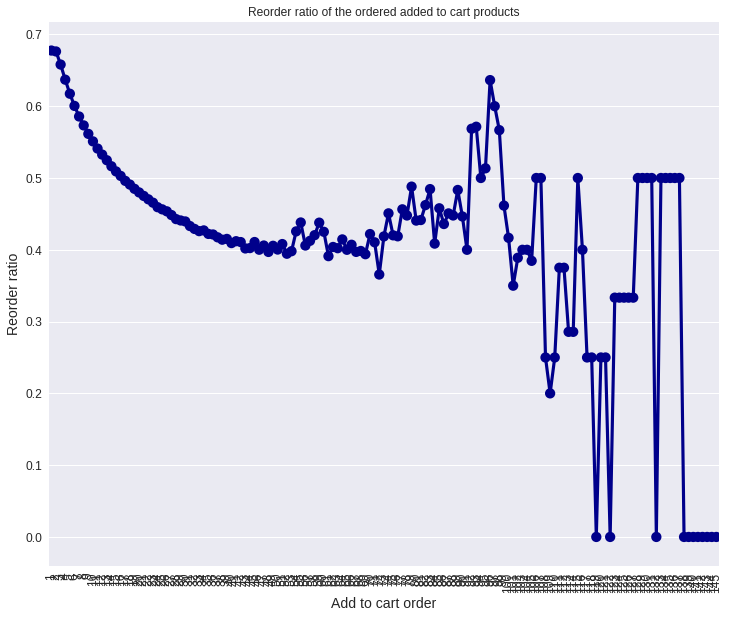

In [38]:
cart_order_df = df_past_orders_info.groupby(["add_to_cart_order"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,10))
sns.pointplot(cart_order_df['add_to_cart_order'].values, cart_order_df['reordered'].values,\
              alpha=0.8, color='darkblue')

plt.ylabel('Reorder ratio')
plt.xlabel('Add to cart order')
plt.title("Reorder ratio of the ordered added to cart products")
plt.xticks(rotation='vertical')
plt.show()

It seems that the products added first to the cart are the ones we're more used to buying, and newer products are only added at the end. The right side of the graph is not as organized as the left side since there are much fewer orders with more than 50 products.

In [39]:
reorder_prob = df_past_orders_info.groupby("product_id")["reordered"]\
               .aggregate({'reordered_times': sum,'total_orders': 'count'}).reset_index()
    
reorder_prob['reorder_prob'] = reorder_prob['reordered_times'] / reorder_prob['total_orders']
reorder_prob = pd.merge(reorder_prob, df_products[['product_id', 'product_name']], how='left', on=['product_id'])
reorder_prob = reorder_prob.sort_values(['reorder_prob'], ascending=False).head(15)

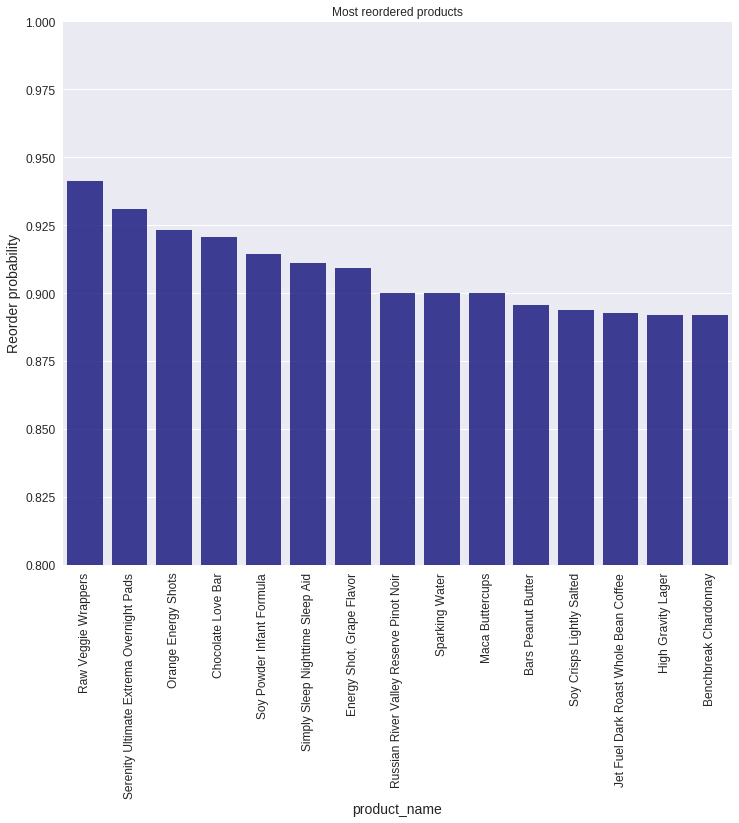

In [40]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(reorder_prob.product_name, reorder_prob.reorder_prob, alpha=0.8, color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Reorder probability')
plt.title('Most reordered products')
ax.set_ylim(0.8, 1)
plt.show()

## Cluster differences

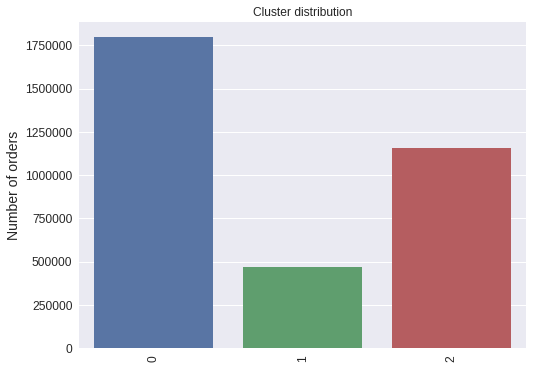

In [48]:
cluster_number = df_orders["cluster"].value_counts()

plt.figure(figsize=(8,6))
sns.barplot(cluster_number.index, cluster_number.values)
plt.ylabel("Number of orders")
plt.xticks(rotation="vertical")
plt.title('Cluster distribution')
plt.show()

In [43]:
df_orders_clusters = pd.merge(df_past_orders_info.sample(frac=0.01), df_orders, on="order_id", how="left")
df_orders_clusters.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
0,888457,42265,6,0,Organic Baby Carrots,123,4,packaged vegetables fruits,produce,114758,prior,2,4,21,30.00000,0
1,571820,31334,7,0,Chocolate Almond & Sea Salt with Chia Granola ...,3,19,energy granola bars,snacks,132244,prior,17,1,9,12.00000,2
2,2389702,12341,5,0,Hass Avocados,32,4,packaged produce,produce,168316,prior,6,6,8,6.00000,0
3,2336601,42188,3,0,Lemon Chamomile Wood Cleaner,114,17,cleaning products,household,59921,prior,11,2,14,5.00000,0
4,1533886,588,9,1,Special K Original Cereal,121,14,cereal,breakfast,23538,prior,5,6,8,14.00000,0


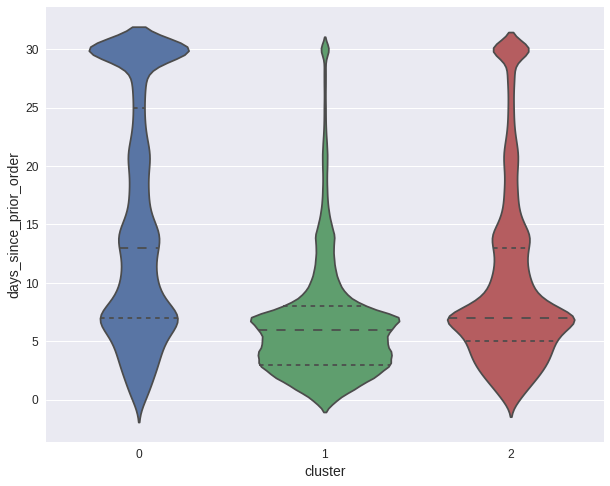

In [51]:
plt.figure(figsize=(10,8))
sns.violinplot(x="cluster", y="days_since_prior_order", data=df_past_orders_info_clusters, split=True, inner="quart")
plt.show();

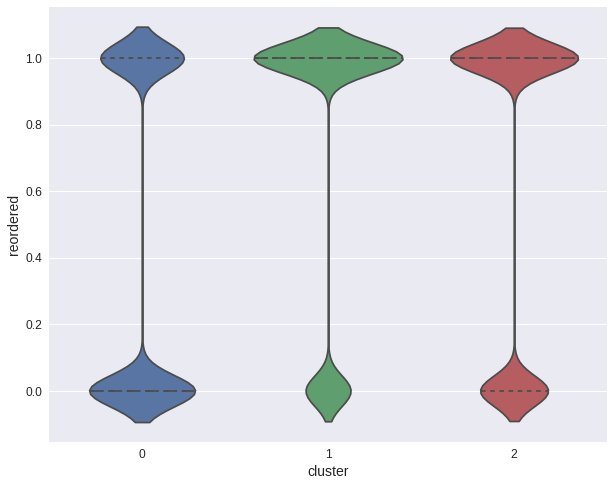

In [55]:
plt.figure(figsize=(10,8))
sns.violinplot(x="cluster", y="reordered", data=df_past_orders_info_clusters, split=True, inner="quart")
plt.show();

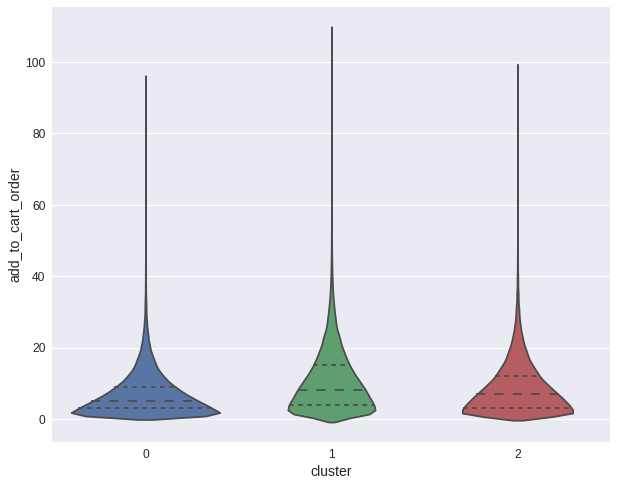

In [56]:
plt.figure(figsize=(10,8))
sns.violinplot(x="cluster", y="add_to_cart_order", data=df_past_orders_info_clusters, split=True, inner="quart")
plt.show();

In [80]:
common_departments = df_past_orders_info_clusters.loc[df_past_orders_info_clusters['department'].isin(products_grouped.department.head().values)]

In [82]:
common_departments = common_departments.groupby(["department",'cluster'])["order_id"].aggregate({'Orders_dept': 'count'}).reset_index()

In [83]:
common_departments

,department,cluster,Orders_dept
0,beverages,0,12760
1,beverages,1,4156
2,beverages,2,10079
3,frozen,0,10366
4,frozen,1,3476
5,frozen,2,8371
6,pantry,0,8329
7,pantry,1,3434
8,pantry,2,7032
9,personal care,0,2368


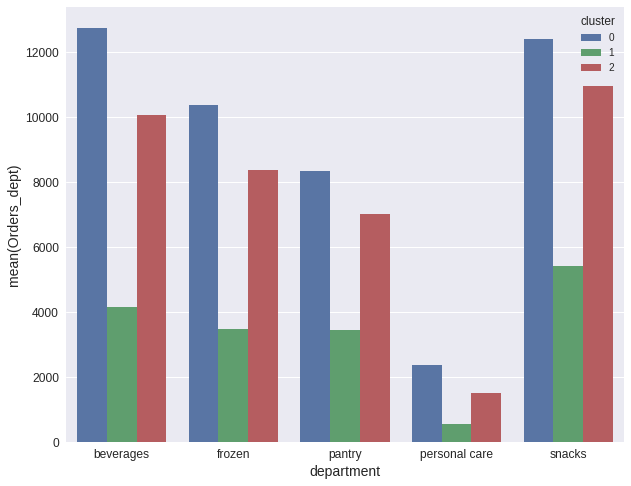

In [85]:
plt.figure(figsize=(10,8))
sns.barplot(x="department", y="Orders_dept", hue="cluster", data=common_departments)
plt.show();